In [81]:
import pandas as pd
import numpy as np
import nibabel as nib
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

In [82]:
# ── Global visualisation configuration ──────────────────────────────────────

# 1.  General Matplotlib defaults
# ── Global visualisation configuration ──────────────────────────────────────
import matplotlib as mpl
import seaborn as sns

mpl.rcParams.update(
    {
        # ── Canvas size & resolution ───────────────────────────────────────────
        # Default figure size: 12×8 inches  →  4800×3200 px when exported at 400 dpi
        "figure.figsize": (12, 8),
        "figure.dpi": 200,  # crisp in-notebook / retina preview
        "savefig.dpi": 400,  # print-quality PNG/PDF
        # ── Fonts ──────────────────────────────────────────────────────────────
        "font.family": "sans-serif",
        "font.sans-serif": ["Roboto", "DejaVu Sans", "Arial"],
        "axes.titlesize": 24,
        # "axes.titleweight": "bold",
        "axes.labelsize": 24,
        "xtick.labelsize": 14,
        "ytick.labelsize": 14,
        "legend.fontsize": 20,
        # ── Axis & spine aesthetics ────────────────────────────────────────────
        "axes.spines.top": False,
        "axes.spines.right": False,
        "axes.spines.left": True,
        "axes.spines.bottom": True,
        "axes.linewidth": 1,
        "axes.grid": True,
        "grid.color": "#E6E6E6",
        "grid.linewidth": 0.4,
        "grid.alpha": 0.8,
        # ── Colour cycle (colour-blind-safe) ───────────────────────────────────
        "axes.prop_cycle": mpl.cycler(color=sns.color_palette("Set2")),
        # ── Figure background ─────────────────────────────────────────────────
        "figure.facecolor": "white",
    }
)

# Seaborn theme inherits the rcParams above
sns.set_theme(context="talk", style="whitegrid", palette="Set2")


# 2.  Seaborn theme (inherits Matplotlib rcParams)
sns.set_theme(
    context="talk",  # slightly larger fonts for presentations / papers
    style="whitegrid",  # grid only on y-axis (good for histograms)
    palette="Set2",  # matches the rcParams colour cycle
)


# 3.  Helper function for consistent figure export
def savefig_nice(fig, filename, *, tight=True, dpi=300, **savefig_kwargs):
    """Save figure with tight layout and correct DPI."""
    if tight:
        fig.tight_layout()
    fig.savefig(filename, dpi=dpi, bbox_inches="tight", transparent=True, **savefig_kwargs)


# 4.  Colour constants for this project (optional convenience)
COL_RAW = "#1f77b4"  # e.g. unweighted sample
COL_WEIGHTED = "#d62728"  # weighted sample
COL_REF = "0.35"  # census reference (neutral grey)

In [83]:
ATLAS = "schaefer2018tian2020_400_7"
region_col = "index"
# Load important files
DATA_DIR = Path("/home/galkepler/Projects/athletes_brain/data")

# Output directory for figures
OUTPUT_DIR = Path("/home/galkepler/Projects/athletes_brain/figures/fig2")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# Load the data
parcels = pd.read_csv(DATA_DIR / "external" / "atlases" / ATLAS / "parcels.csv", index_col=0)
nifti = DATA_DIR / "external" / "atlases" / ATLAS / "atlas.nii.gz"
nifti_matlab = DATA_DIR / "external" / "atlases" / ATLAS / "atlas_matlab.nii"

In [84]:
metrics = ["gm_vol", "wm_vol", "csf_vol", "adc", "fa", "ad", "rd"]
distribution_metric = "qfmean"

bad_subjects = ["IN120120"]

# Load the data
data = {}
for metric in metrics:
    data[metric] = pd.read_csv(DATA_DIR / "processed" / f"{metric}.csv", index_col=0).reset_index(
        drop=True
    )
    # data[metric] = data[metric].drop_duplicates(subset=["subject_code", region_col], keep="last")
    # drop problematic subjects
    data[metric] = data[metric][~data[metric]["subject_code"].isin(bad_subjects)]
    data[metric]["sex"] = data[metric]["sex"].map({"M": 0, "F": 1})


# data["age_squared"] = data["age_at_scan"] ** 2

/tmp/ipykernel_1869895/1396018435.py:9: DtypeWarning: Columns (1,8,9,10,11,12,68) have mixed types. Specify dtype option on import or set low_memory=False.
  data[metric] = pd.read_csv(DATA_DIR / "processed" / f"{metric}.csv", index_col=0).reset_index(
/tmp/ipykernel_1869895/1396018435.py:9: DtypeWarning: Columns (1,8,9,10,11,12,68) have mixed types. Specify dtype option on import or set low_memory=False.
  data[metric] = pd.read_csv(DATA_DIR / "processed" / f"{metric}.csv", index_col=0).reset_index(
/tmp/ipykernel_1869895/1396018435.py:9: DtypeWarning: Columns (1,8,9,10,11,12,68) have mixed types. Specify dtype option on import or set low_memory=False.
  data[metric] = pd.read_csv(DATA_DIR / "processed" / f"{metric}.csv", index_col=0).reset_index(
/tmp/ipykernel_1869895/1396018435.py:9: DtypeWarning: Columns (16,23,24,25,26,27,33) have mixed types. Specify dtype option on import or set low_memory=False.
  data[metric] = pd.read_csv(DATA_DIR / "processed" / f"{metric}.csv", index_col=0

In [85]:
metric_cols = {metric: "volume" if "vol" in metric else distribution_metric for metric in metrics}

for m, df in data.items():
    df = df.rename(columns={metric_cols[m]: "value"})
    data[m] = df

In [86]:
import pandas as pd
import numpy as np
from functools import reduce

# Assuming 'region_col' is defined globally (e.g., 'Region_Name' or 'Region_ID')
# Make sure to define it if not already:
# region_col = 'Region_ID' # Example, adapt to your actual region column name


# --- Adapted `long_to_wide` Function ---
def long_to_wide(
    long_df,
    *,
    index_cols=["subject_code", "session_id"],  # Use both for unique sessions
    columns_to_pivot=region_col,  # Your region column name
    values_col="value",
    demographic_cols=[
        "age_at_scan",
        "sex",
        "group",
        "target",
        "tiv",
    ],  # Include all relevant demographics/targets
):
    """
    Pivots a long metric table to a wide DataFrame (sessions x features),
    while preserving demographic and target columns.

    Parameters
    ----------
    long_df : pd.DataFrame
        Input DataFrame in long format with columns like index_cols, columns_to_pivot,
        values_col, and demographic_cols.
    index_cols : list of str
        Columns to use as the index for pivoting (e.g., ['Participant_ID', 'Session_ID']).
    columns_to_pivot : str
        Column containing the region names/IDs to become new columns.
    values_col : str
        Column containing the metric values.
    demographic_cols : list of str
        Other columns to preserve (demographics, target variables).

    Returns
    -------
    pd.DataFrame
        Wide-format DataFrame with (Participant_ID, Session_ID) as a multi-index,
        region values as columns (prefixed with metric type), and
        demographic/target columns.
    """
    # Ensure all index_cols and demographic_cols are in the DataFrame
    if not all(col in long_df.columns for col in index_cols + [columns_to_pivot, values_col]):
        raise ValueError(
            f"Missing essential columns for pivoting. Required: {index_cols + [columns_to_pivot, values_col]}"
        )

    # Filter demographic_cols to only those actually present in the long_df
    present_demographic_cols = [col for col in demographic_cols if col in long_df.columns]

    # Handle multiple sessions per participant if Session_ID is not explicit
    if "session_id" not in long_df.columns:
        long_df["session_id"] = long_df.groupby("Participant_ID").cumcount() + 1
        print(
            "  Warning: 'Session_ID' not found in long_df. Generated dummy Session_ID for pivoting."
        )

    # Select columns to pivot and drop duplicates for the index/demographics
    # We drop duplicates to ensure only one set of demographic/target data per session
    meta_df = long_df[index_cols + present_demographic_cols].drop_duplicates(subset=index_cols)
    meta_df = meta_df.set_index(index_cols)

    # Pivot the metric data
    wide_metric = long_df.pivot_table(
        index=index_cols, columns=columns_to_pivot, values=values_col
    )

    # Merge demographics back. Ensure column names from wide_metric are unique.
    # The columns from wide_metric are already the region names, no prefix needed here yet.
    full_wide_df = meta_df.join(
        wide_metric, how="inner"
    )  # Inner join to ensure only sessions with metric data

    # Optional: Missing value thresholding
    # These thresholds might need careful consideration in a multimodal context
    # as dropping columns from one metric might affect others later.
    # For initial combined ML, it's often better to drop NaNs at the end on the full feature set.
    # You can re-enable if you want to filter per-metric-wise first.
    # thresh_cols = int(0.8 * len(full_wide_df))
    # full_wide_df = full_wide_df.dropna(axis=1, thresh=thresh_cols)
    # thresh_rows = int(0.8 * len(wide_metric.columns)) # Assuming parcels is wide_metric.columns
    # full_wide_df = full_wide_df.dropna(axis=0, thresh=thresh_rows)

    return full_wide_df.reset_index()

In [108]:
common_sessions = []
data_wide = {}
for metric, df in data.items():
    data_wide[metric] = long_to_wide(df)
    common_sessions.append(set(data_wide[metric]["session_id"].unique()))
# Find common sessions across all metrics
common_sessions = reduce(lambda x, y: x.intersection(y), common_sessions)
# Filter each metric DataFrame to only include common sessions
for metric in data_wide:
    data_wide[metric] = data_wide[metric][data_wide[metric]["session_id"].isin(common_sessions)]




In [109]:
from sklearn.pipeline import make_pipeline
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier  # or any other classifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression, SGDClassifier

# fit the model (split)
from sklearn.model_selection import train_test_split
from sklearn.model_selection import permutation_test_score


def init_preprocessor(X):
    return ColumnTransformer(
        [
            ("num", StandardScaler(), X.select_dtypes(include="number").columns),
            ("cat", OneHotEncoder(), X.select_dtypes(include="object").columns),
        ]
    )


In [110]:
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import cross_val_predict

AVAILABLE_MODELS = {
    "sgd": SGDClassifier(random_state=42, class_weight="balanced", max_iter=int(1e6)),
    "rf": RandomForestClassifier(random_state=42, class_weight="balanced", n_jobs=-1),
    "svm": SVC(random_state=42, class_weight="balanced", kernel="rbf", probability=True),
    "logreg": LogisticRegression(random_state=42, class_weight="balanced", max_iter=int(1e6)),
}

AVAILABLE_PARAMS = {
    "sgd": {
        "classifier__alpha": [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
        "classifier__loss": ["modified_huber", "log_loss"],
        "classifier__penalty": ["l1", "l2", "elasticnet"],
        "classifier__l1_ratio": [0.15, 0.5, 0.85],
    },
    "rf": {
        "classifier__n_estimators": [100, 200, 300],
        "classifier__max_depth": [5, 50, 100, None],
        "classifier__max_features": ["auto", "sqrt"],
        "classifier__min_samples_split": [2, 5, 10],
        "classifier__min_samples_leaf": [1, 2, 4],
        "classifier__bootstrap": [True, False],
    },
    "svm": {
        "classifier__C": [0.1, 1, 10, 100, 1000],
        "classifier__kernel": ["linear", "rbf", "poly"],
        "classifier__gamma": ["scale", "auto"],
        "classifier__degree": [2, 3, 4],  # Only relevant for 'poly' kernel
    },
    "logreg": {
        "classifier__C": [0.1, 1, 10, 100, 1000],
        "classifier__penalty": ["l1", "l2"],
        "classifier__solver": ["liblinear"],  # 'liblinear' supports 'l1' and 'l2' penalties
    }, 
}

cv = GroupKFold(n_splits=5, shuffle=True, random_state=42)

In [ ]:
N_PERMUTATIONS = 1000  # Number of permutations for significance testing
MODEL = "sgd"
GROUPS = [None, "climbing", "bjj"]
GROUP_NAMES = {
    None: "all",
    "climbing": "climbing",
    "bjj": "bjj",
}
df_template = pd.DataFrame(
    columns=["scorer", "fold", "score", "permutation_score", "pvalue", "permutations"]
)
predictions_template = pd.DataFrame(columns=["true", "proba"])


results = {g: {m: df_template.copy() for m in data_wide.keys()} for g in GROUP_NAMES.values()}
predictions = {
    g: {m: predictions_template.copy() for m in data_wide.keys()} for g in GROUP_NAMES.values()
}

for GROUP, GROUP_NAME in GROUP_NAMES.items():
    for i, metric in enumerate(data_wide.keys()):
        CUR_DEST = OUTPUT_DIR / GROUP_NAME / metric
        CUR_DEST.mkdir(parents=True, exist_ok=True)
        if metric != "adc":
            continue
        print(f"\n--- Evaluating ({GROUP_NAME}) - {metric.upper()} ---")
        measure_df = df_template.copy()
        predictions_df = predictions_template.copy()
        m_data = data_wide[metric].copy()
        if GROUP is not None:
            # drop athletes not in the group
            m_data = m_data.drop(m_data[m_data["target"] & (m_data["group"].astype(str).str.lower() != GROUP)].index)
        X = m_data.drop(columns=["subject_code", "session_id", "group", "target"])
        X["sex"] = X["sex"].astype("str")
        y = m_data["target"]
        groups = m_data["subject_code"].astype("str")
        if "vol" in metric:
            # divide by TIV to normalize
            tiv = data_wide[metric]["tiv"]
            X[parcels[region_col]] = X[parcels[region_col]].div(tiv, axis=0)
        X.columns = X.columns.astype(str)  # Ensure all column names are strings for consistency

        print(f"X shape: {X.shape}, y shape: {y.shape}")
        print(y.value_counts(normalize=False))
        print(y.value_counts(normalize=True))

        preprocessor = init_preprocessor(X)
        # Define the pipeline
        pipe = Pipeline(
            [
                ("preprocessor", preprocessor),
                ("imputer", SimpleImputer(strategy="mean")),
                # ("oversampler", RandomOverSampler(random_state=42)),
                ("classifier", AVAILABLE_MODELS[MODEL]),
            ]
        )

        # Define the grid search
        grid = GridSearchCV(pipe, AVAILABLE_PARAMS[MODEL], cv=cv, n_jobs=-1, scoring="average_precision", verbose=1)

        # Fit the grid search
        grid.fit(X, y, groups=groups)

        for scorer in ["average_precision", "roc_auc", "f1"]:
            scores = cross_val_score(grid.best_estimator_, X, y, cv=cv, scoring=scorer, groups=groups, n_jobs=-1)
            print(f"{scorer} mean: {np.mean(scores)}, std: {np.std(scores)}")
            splits = cv.split(X, y, groups=groups)
            perm_score, permutation_scores, pvalue = permutation_test_score(
                grid.best_estimator_, X, y, cv=splits, scoring=scorer, n_permutations=N_PERMUTATIONS, n_jobs=-1
            )
            # break
            for fold, score in enumerate(scores):
                measure_df.loc[len(measure_df)] = [
                    scorer,
                    fold,
                    score,
                    perm_score,
                    pvalue,
                    permutation_scores,
                ]
        results[GROUP_NAME][metric] = measure_df
        predictions_df["true"] = y
        predictions_df["proba"] = cross_val_predict(
            grid.best_estimator_, X, y, cv=cv, groups=groups, n_jobs=-1, method="predict_proba"
        )[:, 1]
        predictions[GROUP_NAME][metric] = predictions_df
        print(f"Saving results for {GROUP_NAME} - {metric}")
        results[GROUP_NAME][metric].to_csv(CUR_DEST / "results.csv")
        predictions[GROUP_NAME][metric].to_csv(CUR_DEST / "predictions.csv")
        # Save the best model
        best_model = grid.best_estimator_
        with open(CUR_DEST / "best_model.pkl", "wb") as f:
            import pickle
            pickle.dump(best_model, f)
        print(f"Best model saved for {GROUP_NAME} - {metric}")


--- Evaluating (all) - ADC ---
X shape: (1210, 456), y shape: (1210,)
target
False    1025
True      185
Name: count, dtype: int64
target
False    0.847107
True     0.152893
Name: proportion, dtype: float64
Fitting 5 folds for each of 126 candidates, totalling 630 fits


KeyboardInterrupt: 

In [ ]:
for GROUP, GROUP_NAME in GROUP_NAMES.items():
    print(f"\n--- Applying stacking for {GROUP_NAME} ---")
    stacked_models = parcels.copy()
    stacked_estimators = {roi: {} for roi in stacked_models[region_col]}
    predictions[GROUP_NAME]["base_stacked"] = {}

    alphas = np.logspace(-3, 4, 30)  # ridge grid

    # initiate CV
    cv = GroupKFold(n_splits=5, shuffle=True, random_state=42)

    tmp = pd.DataFrame(index=list(common_sessions), columns = ["subject_code", "group", "target"] + list(data_wide.keys()))
    for metric, df in data_wide.items():
        # get the values for the current parcel
        m_v = df.set_index("session_id")
        # drop duplicated index
        m_v = m_v[~m_v.index.duplicated(keep="first")]
        tmp[metric] = m_v[1]
        #     df.set_index("session_id")[roi].astype(float).drop_duplicates(keep="first")
        # )
        # add subject_code, session_id, group, target
        tmp[["subject_code", "age_at_scan", "sex", "group", "target"]] = m_v[
            ["subject_code", "age_at_scan", "sex", "group", "target"]
        ]
    if GROUP is not None:
        # drop athletes not in the group
        tmp = tmp.drop(tmp[tmp["target"] & (tmp["group"].astype(str).str.lower() != GROUP)].index)
    # get subjects from the common sessions
    subjects = tmp["subject_code"].astype(str)

    # fit cv to subjects to ensure that the groups are preserved across folds
    splits = cv.split(subjects)

    for i, row in parcels.iterrows():  # i == parcel index (0..453)
        learner_df = df_template.copy()
        # ------------- build design matrix for parcel i -----------------
        # X_roi : (n_subjects , 5 metrics)
        # X_cov = cov[cov_names["gm_vol"]].to_numpy()
        roi = row[region_col]  # e.g. 'V1'
        vals = pd.DataFrame(index=list(common_sessions), columns = ["subject_code", "group", "target"] + list(data_wide.keys()))
        for metric, df in data_wide.items():
            # get the values for the current parcel
            m_v = df.set_index("session_id")
            # drop duplicated index
            m_v = m_v[~m_v.index.duplicated(keep="first")]
            vals[metric] = m_v[roi]
            #     df.set_index("session_id")[roi].astype(float).drop_duplicates(keep="first")
            # )
            # add subject_code, session_id, group, target
            vals[["subject_code", "age_at_scan", "sex", "group", "target"]] = m_v[
                ["subject_code", "age_at_scan", "sex", "group", "target"]
            ]

        # drop athletes not in the group
        if GROUP is not None:
            vals = vals.drop(vals[vals["target"] & (vals["group"].astype(str).str.lower() != GROUP)].index)

        y = vals["target"]
        X_roi = vals.drop(columns=["subject_code", "group", "target"])

        print(f"Parcel {roi} - X shape: {X_roi.shape}, y shape: {y.shape}")
        print(y.value_counts(normalize=True))
        # ------------- fit the model -----------------
        preprocessor = init_preprocessor(X_roi)
        # Define the pipeline
        pipe = Pipeline(
            [
                ("preprocessor", preprocessor),
                ("imputer", SimpleImputer(strategy="mean")),
                # ("oversampler", RandomOverSampler(random_state=42)),
                ("classifier", AVAILABLE_MODELS[MODEL]),
            ]
        )
        # Define the grid search
        grid = GridSearchCV(
            pipe,
            AVAILABLE_PARAMS[MODEL],
            cv=cv,
            n_jobs=-1,
            scoring="average_precision",
            verbose=1,
        )
        # Fit the grid search
        grid.fit(X_roi, y, groups=subjects)

        # Store the best estimator for this parcel
        stacked_estimators[roi]["estimator"] = grid.best_estimator_
        for scorer in ["average_precision", "roc_auc", "f1"]:
            scores = cross_val_score(
                grid.best_estimator_, X_roi, y, cv=cv, scoring=scorer, groups=subjects, n_jobs=-1
            )
            print(f"{scorer} mean: {np.mean(scores)}, std: {np.std(scores)}")
            splits = cv.split(X_roi, y, groups=subjects)
            perm_score, permutation_scores, pvalue = permutation_test_score(
                grid.best_estimator_,
                X_roi,
                y,
                cv=splits,
                scoring=scorer,
                n_permutations=N_PERMUTATIONS,
                n_jobs=-1,
            )
            # break
            for fold, score in enumerate(scores):
                learner_df.loc[len(learner_df)] = [
                    scorer,
                    fold,
                    score,
                    perm_score,
                    pvalue,
                    permutation_scores,
                ]
                stacked_models.loc[i, f"{scorer}-{fold}"] = score
        # Store the predictions for this parcel
        predictions_df = pd.DataFrame(
            {
                "true": y,
                "proba": cross_val_predict(
                    grid.best_estimator_, X_roi, y, cv=cv, groups=subjects, n_jobs=-1, method="predict_proba"
                )[:, 1],
            }
        )
        predictions[GROUP_NAME]["base_stacked"][roi] = predictions_df

    # Save the results for the parcel
    CUR_DEST = OUTPUT_DIR / GROUP_NAME / "stacked"
    CUR_DEST.mkdir(parents=True, exist_ok=True)
    stacked_models.to_csv(CUR_DEST / "results.csv")
    # save OOF predictions
    # predictions_df = pd.DataFrame(predictions["base_stacked"]).T

    break


--- Applying stacking for all ---
Parcel 1 - X shape: (1203, 9), y shape: (1203,)
target
False    0.846218
True     0.153782
Name: proportion, dtype: float64
Fitting 5 folds for each of 126 candidates, totalling 630 fits
average_precision mean: 0.2925021091656033, std: 0.050254097181692686
roc_auc mean: 0.6769581064720231, std: 0.05539364706043105
f1 mean: 0.3405823694719663, std: 0.023289469858404906
Parcel 2 - X shape: (1203, 9), y shape: (1203,)
target
False    0.846218
True     0.153782
Name: proportion, dtype: float64
Fitting 5 folds for each of 126 candidates, totalling 630 fits
average_precision mean: 0.30014493778251083, std: 0.06287982729719438
roc_auc mean: 0.705450493018277, std: 0.037424291600850895
f1 mean: 0.3526665620296193, std: 0.0381169307303196
Parcel 3 - X shape: (1203, 9), y shape: (1203,)
target
False    0.846218
True     0.153782
Name: proportion, dtype: float64
Fitting 5 folds for each of 126 candidates, totalling 630 fits
average_precision mean: 0.289539620569

In [ ]:
for GROUP, GROUP_NAME in GROUP_NAMES.items():
    print(f"\n--- Fitting stacked model for {GROUP_NAME} ---")
    learner_df = df_template.copy()
    # use predictions of base stacked
    new_X = pd.DataFrame(
        {roi: predictions["base_stacked"][roi]["proba"] for roi in stacked_estimators.keys()},
        index=predictions["base_stacked"][list(stacked_estimators.keys())[0]].index,
    )
    # add sex, age, group, target
    new_X = new_X.join(
        tmp[["age_at_scan", "sex"]]
    )

    new_X.columns = new_X.columns.astype(str)  # Ensure all column names are strings for consistency

    y = tmp["target"]

    # Fit a new model on the stacked predictions
    preprocessor = init_preprocessor(new_X)
    # Define the pipeline
    pipe = Pipeline(
        [
            ("preprocessor", preprocessor),
            ("imputer", SimpleImputer(strategy="mean")),
            # ("oversampler", RandomOverSampler(random_state=42)),
            ("classifier", AVAILABLE_MODELS[MODEL]),
        ]
    )
    # Define the grid search
    grid = GridSearchCV(
        pipe,
        AVAILABLE_PARAMS[MODEL],
        cv=cv,
        n_jobs=-1,
        scoring="average_precision",
        verbose=1,
    )
    # Fit the grid search
    grid.fit(new_X, y, groups=subjects)
    
    # Store the best estimator for the stacked model
    stacked_estimators["stacked_model"] = grid.best_estimator_

    for scorer in ["average_precision", "roc_auc", "f1"]:
        scores = cross_val_score(
            grid.best_estimator_, new_X, y, cv=cv, scoring=scorer, groups=subjects, n_jobs=-1
        )
        print(f"{scorer} mean: {np.mean(scores)}, std: {np.std(scores)}")
        splits = cv.split(new_X, y, groups=subjects)
        perm_score, permutation_scores, pvalue = permutation_test_score(
            grid.best_estimator_,
            new_X,
            y,
            cv=splits,
            scoring=scorer,
            n_permutations=N_PERMUTATIONS,
            n_jobs=-1,
        )
        # break
        for fold, score in enumerate(scores):
            learner_df.loc[len(learner_df)] = [
                scorer,
                fold,
                score,
                perm_score,
                pvalue,
                permutation_scores,
            ]
    # Store the predictions for the stacked model
    predictions_df = pd.DataFrame(
        {
            "true": y,
            "proba": cross_val_predict(
                grid.best_estimator_, new_X, y, cv=cv, groups=subjects, n_jobs=-1, method="predict_proba"
            )[:, 1],
        }
    )
    predictions[GROUP_NAME]["stacked"] = predictions_df
    # Save the results for the stacked model
    CUR_DEST = OUTPUT_DIR / GROUP_NAME / "stacked"
    CUR_DEST.mkdir(parents=True, exist_ok=True)
    learner_df.to_csv(CUR_DEST / "results.csv")
    # Save the best model
    with open(CUR_DEST / "best_model.pkl", "wb") as f:
        import pickle
        pickle.dump(grid.best_estimator_, f)


Fitting 5 folds for each of 126 candidates, totalling 630 fits


GridSearchCV(cv=GroupKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         Index(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10',
       ...
       '447', '448', '449', '450', '451', '452', '453', '454', 'age_at_scan',
       'sex'],
      dtype='object', length=456)),
                                                                        ('cat',
                                                                         OneHotEncoder(),
                                                                         Index([], dtyp...
                                       ('imputer', SimpleImputer()),
                                       ('classifier',
                                        SGDClassifier(class_weight='balanced',
                                                      max_iter=1000000,
                                                      random_state=42))]),
             n_jobs=-1,
             param_grid={'classifier__alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10,
                                               100],
                         'classifier__l1_ratio': [0.15, 0.5, 0.85],
                         'classifier__loss': ['modified_huber', 'log_loss'],
                         'classifier__penalty': ['l1', 'l2', 'elasticnet']},
             scoring='average_precision', verbose=1)

In [220]:
splits = cv.split(new_X, y, groups=subjects)
perm_score, permutation_scores, pvalue = permutation_test_score(
    grid.best_estimator_,
    new_X,
    y,
    cv=splits,
    scoring="average_precision",
    n_permutations=N_PERMUTATIONS,
    n_jobs=-1,
)

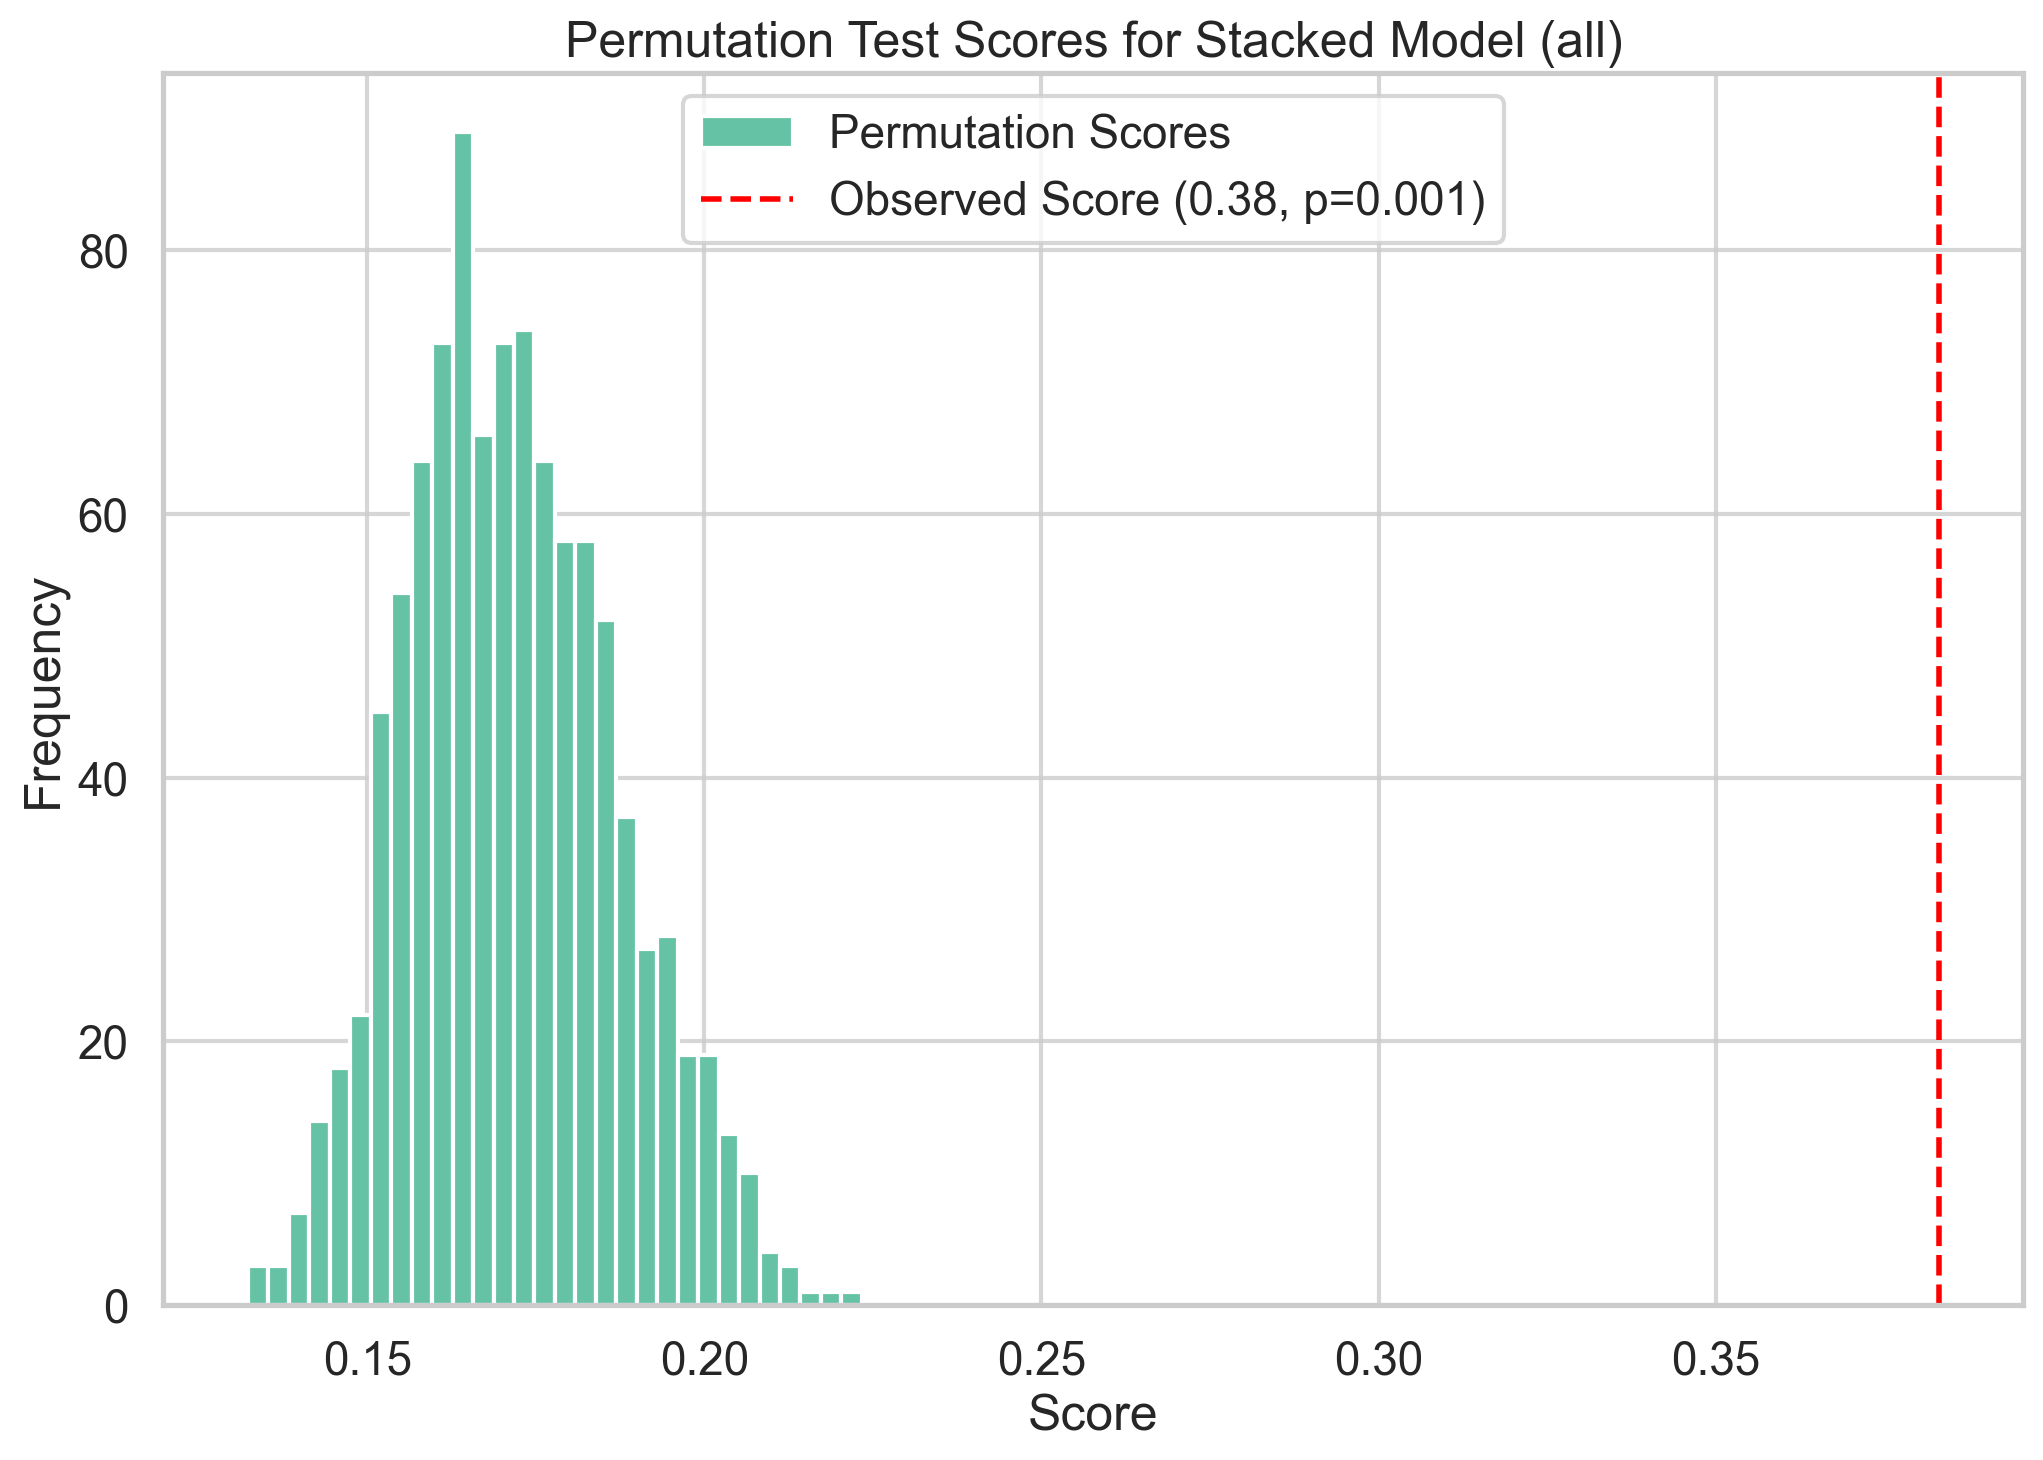

In [221]:
scorer = "average_precision"
obs = perm_score
p = pvalue
plt.hist(
    permutation_scores,
    bins=30,
    label="Permutation Scores",
)
plt.axvline(
    x=obs,
    color="red",
    linestyle="dashed",
    linewidth=2,
    label="Observed Score ({:.2f}, p={:.3f})".format(obs, p),
)
plt.title(f"Permutation Test Scores for Stacked Model ({GROUP_NAME})")
plt.xlabel("Score")

plt.ylabel("Frequency")
plt.legend()

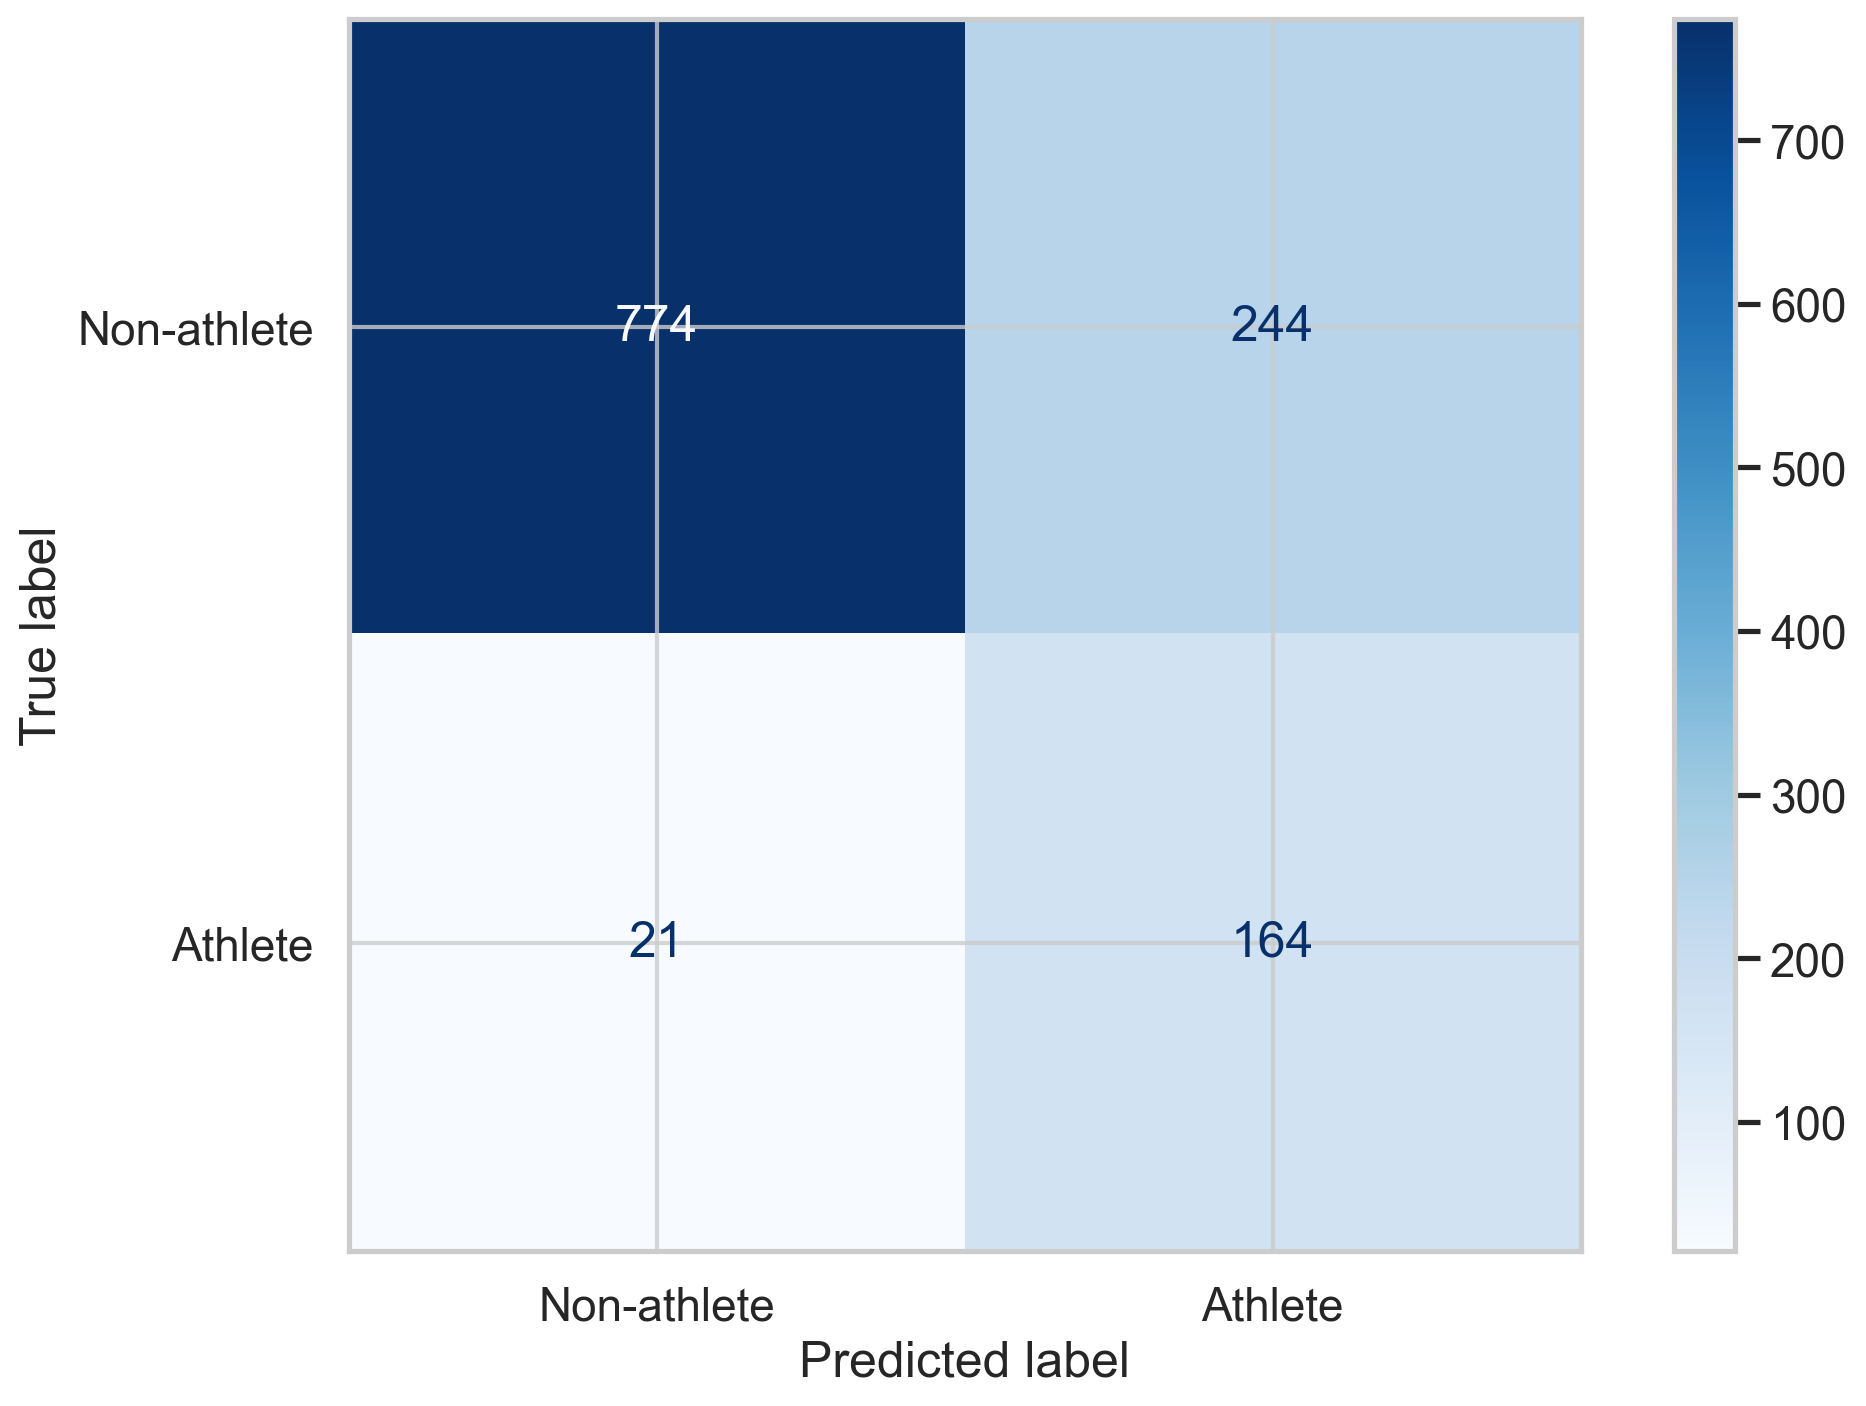

In [222]:
# confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
y_pred = grid.predict(new_X)
cm = confusion_matrix(y, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non-athlete", "Athlete"])   
disp.plot(cmap=plt.cm.Blues)

In [225]:
tmp_conf = tmp.copy()
tmp_conf["predicted"] = y_pred
tmp_conf["proba"] = grid.predict_proba(new_X)[:, 1]
tmp_conf[~tmp_conf["target"] & (tmp_conf["predicted"] == 1)].sort_values(
    by="proba", ascending=False)

,subject_code,group,target,gm_vol,wm_vol,csf_vol,adc,fa,ad,rd,age_at_scan,sex,predicted,proba
202406131027,BB00889,Army,False,1861.260707,417.799793,125.553892,0.000787,0.174574,0.000934,0.000716,25.11,0,True,0.926489
202211281104,860,Snbb,False,1540.350630,314.428263,145.905495,0.000792,0.179029,0.000942,0.000719,29.37,0,True,0.924600
202304101926,BB00449,Snbb,False,1726.695731,374.544318,127.565004,0.000781,0.175167,0.000929,0.000711,34.64,0,True,0.915069
202401021616,BJJL26,Bjj,False,2062.709381,552.839779,233.660802,0.000825,0.181913,0.000981,0.000751,24.27,0,True,0.910062
202404211224,BJJL26,Bjj,False,1943.018030,607.246732,220.493774,0.000831,0.173550,0.000986,0.000758,24.57,0,True,0.900274
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202301302016,BB00406,Snbb,False,1927.274674,417.660035,140.316838,0.000794,0.171463,0.000943,0.000723,24.99,0,True,0.503865
202308061753,1022,Python,False,1648.047473,405.557648,220.258358,0.000827,0.187735,0.000992,0.000747,28.01,0,True,0.503717
202503240848,BJJL193,Bjj,False,1479.830979,426.214913,114.263556,0.000779,0.167347,0.000921,0.000711,36.94,0,True,0.502543
202207120834,691,Bjj,False,1542.598647,315.517234,127.335064,0.000784,0.176156,0.000928,0.000714,30.44,0,True,0.502281


In [196]:
# transform stacked_models to long format - (parcels x scorer x fold x score)
stacked_models_long = stacked_models.melt(
    id_vars=parcels.columns.tolist(),
    var_name="scorer_fold",
    value_name="score",
)
stacked_models_long[["scorer", "fold"]] = stacked_models_long["scorer_fold"].str.split("-", expand=True)
stacked_models_long = stacked_models_long.drop(columns=["scorer_fold"])
stacked_models_long[stacked_models_long[region_col] == 1]

,index,name,base_name,Label Name,network,component,hemisphere,score,scorer,fold
0,1,7Networks_LH_Vis_1,7networks_lh_vis,7Networks_LH_Vis,visual,visual,L,0.194671,average_precision,0
454,1,7Networks_LH_Vis_1,7networks_lh_vis,7Networks_LH_Vis,visual,visual,L,0.314312,average_precision,1
908,1,7Networks_LH_Vis_1,7networks_lh_vis,7Networks_LH_Vis,visual,visual,L,0.298232,average_precision,2
1362,1,7Networks_LH_Vis_1,7networks_lh_vis,7Networks_LH_Vis,visual,visual,L,0.333874,average_precision,3
1816,1,7Networks_LH_Vis_1,7networks_lh_vis,7Networks_LH_Vis,visual,visual,L,0.321422,average_precision,4
2270,1,7Networks_LH_Vis_1,7networks_lh_vis,7Networks_LH_Vis,visual,visual,L,0.593443,roc_auc,0
2724,1,7Networks_LH_Vis_1,7networks_lh_vis,7Networks_LH_Vis,visual,visual,L,0.751120,roc_auc,1
3178,1,7Networks_LH_Vis_1,7networks_lh_vis,7Networks_LH_Vis,visual,visual,L,0.715441,roc_auc,2
3632,1,7Networks_LH_Vis_1,7networks_lh_vis,7Networks_LH_Vis,visual,visual,L,0.640459,roc_auc,3
4086,1,7Networks_LH_Vis_1,7networks_lh_vis,7Networks_LH_Vis,visual,visual,L,0.684327,roc_auc,4


In [205]:
agg = {p: "first" for p in parcels.columns.tolist() if p != region_col}
agg["score"] = "mean"  # or 'median' if you prefer
s = stacked_models_long.groupby([region_col, "scorer"]).aggregate(agg).reset_index()
s[s["scorer"] == "average_precision"].sort_values("score", ascending=False).head(10)

,index,scorer,name,base_name,Label Name,network,component,hemisphere,score
804,269,average_precision,7Networks_RH_SomMot_39,7networks_rh_sommot,7Networks_RH_SomMot,somatomotor,somatomotor,R,0.363762
786,263,average_precision,7Networks_RH_SomMot_33,7networks_rh_sommot,7Networks_RH_SomMot,somatomotor,somatomotor,R,0.362781
12,5,average_precision,7Networks_LH_Vis_5,7networks_lh_vis,7Networks_LH_Vis,visual,visual,L,0.349447
573,192,average_precision,7Networks_LH_Default_pCunPCC_3,7networks_lh_default_pcunpcc,7Networks_LH_Default_pCunPCC,default,precuneus posterior cingulate cortex,L,0.346170
324,109,average_precision,7Networks_LH_SalVentAttn_Med_3,7networks_lh_salventattn_med,7Networks_LH_SalVentAttn_Med,salience / ventral attention,medial,L,0.344350
1245,416,average_precision,PUT-DP-rh,PUT-DP,"Putamen, dorso-posterior part",subcortex,Putamen,R,0.343912
654,219,average_precision,7Networks_RH_Vis_19,7networks_rh_vis,7Networks_RH_Vis,visual,visual,R,0.342812
300,101,average_precision,7Networks_LH_SalVentAttn_FrOperIns_5,7networks_lh_salventattn_froperins,7Networks_LH_SalVentAttn_FrOperIns,salience / ventral attention,frontal operculum insula,L,0.342498
219,74,average_precision,7Networks_LH_DorsAttn_Post_6,7networks_lh_dorsattn_post,7Networks_LH_DorsAttn_Post,dorsal attention,posterior,L,0.341182
606,203,average_precision,7Networks_RH_Vis_3,7networks_rh_vis,7Networks_RH_Vis,visual,visual,R,0.340640


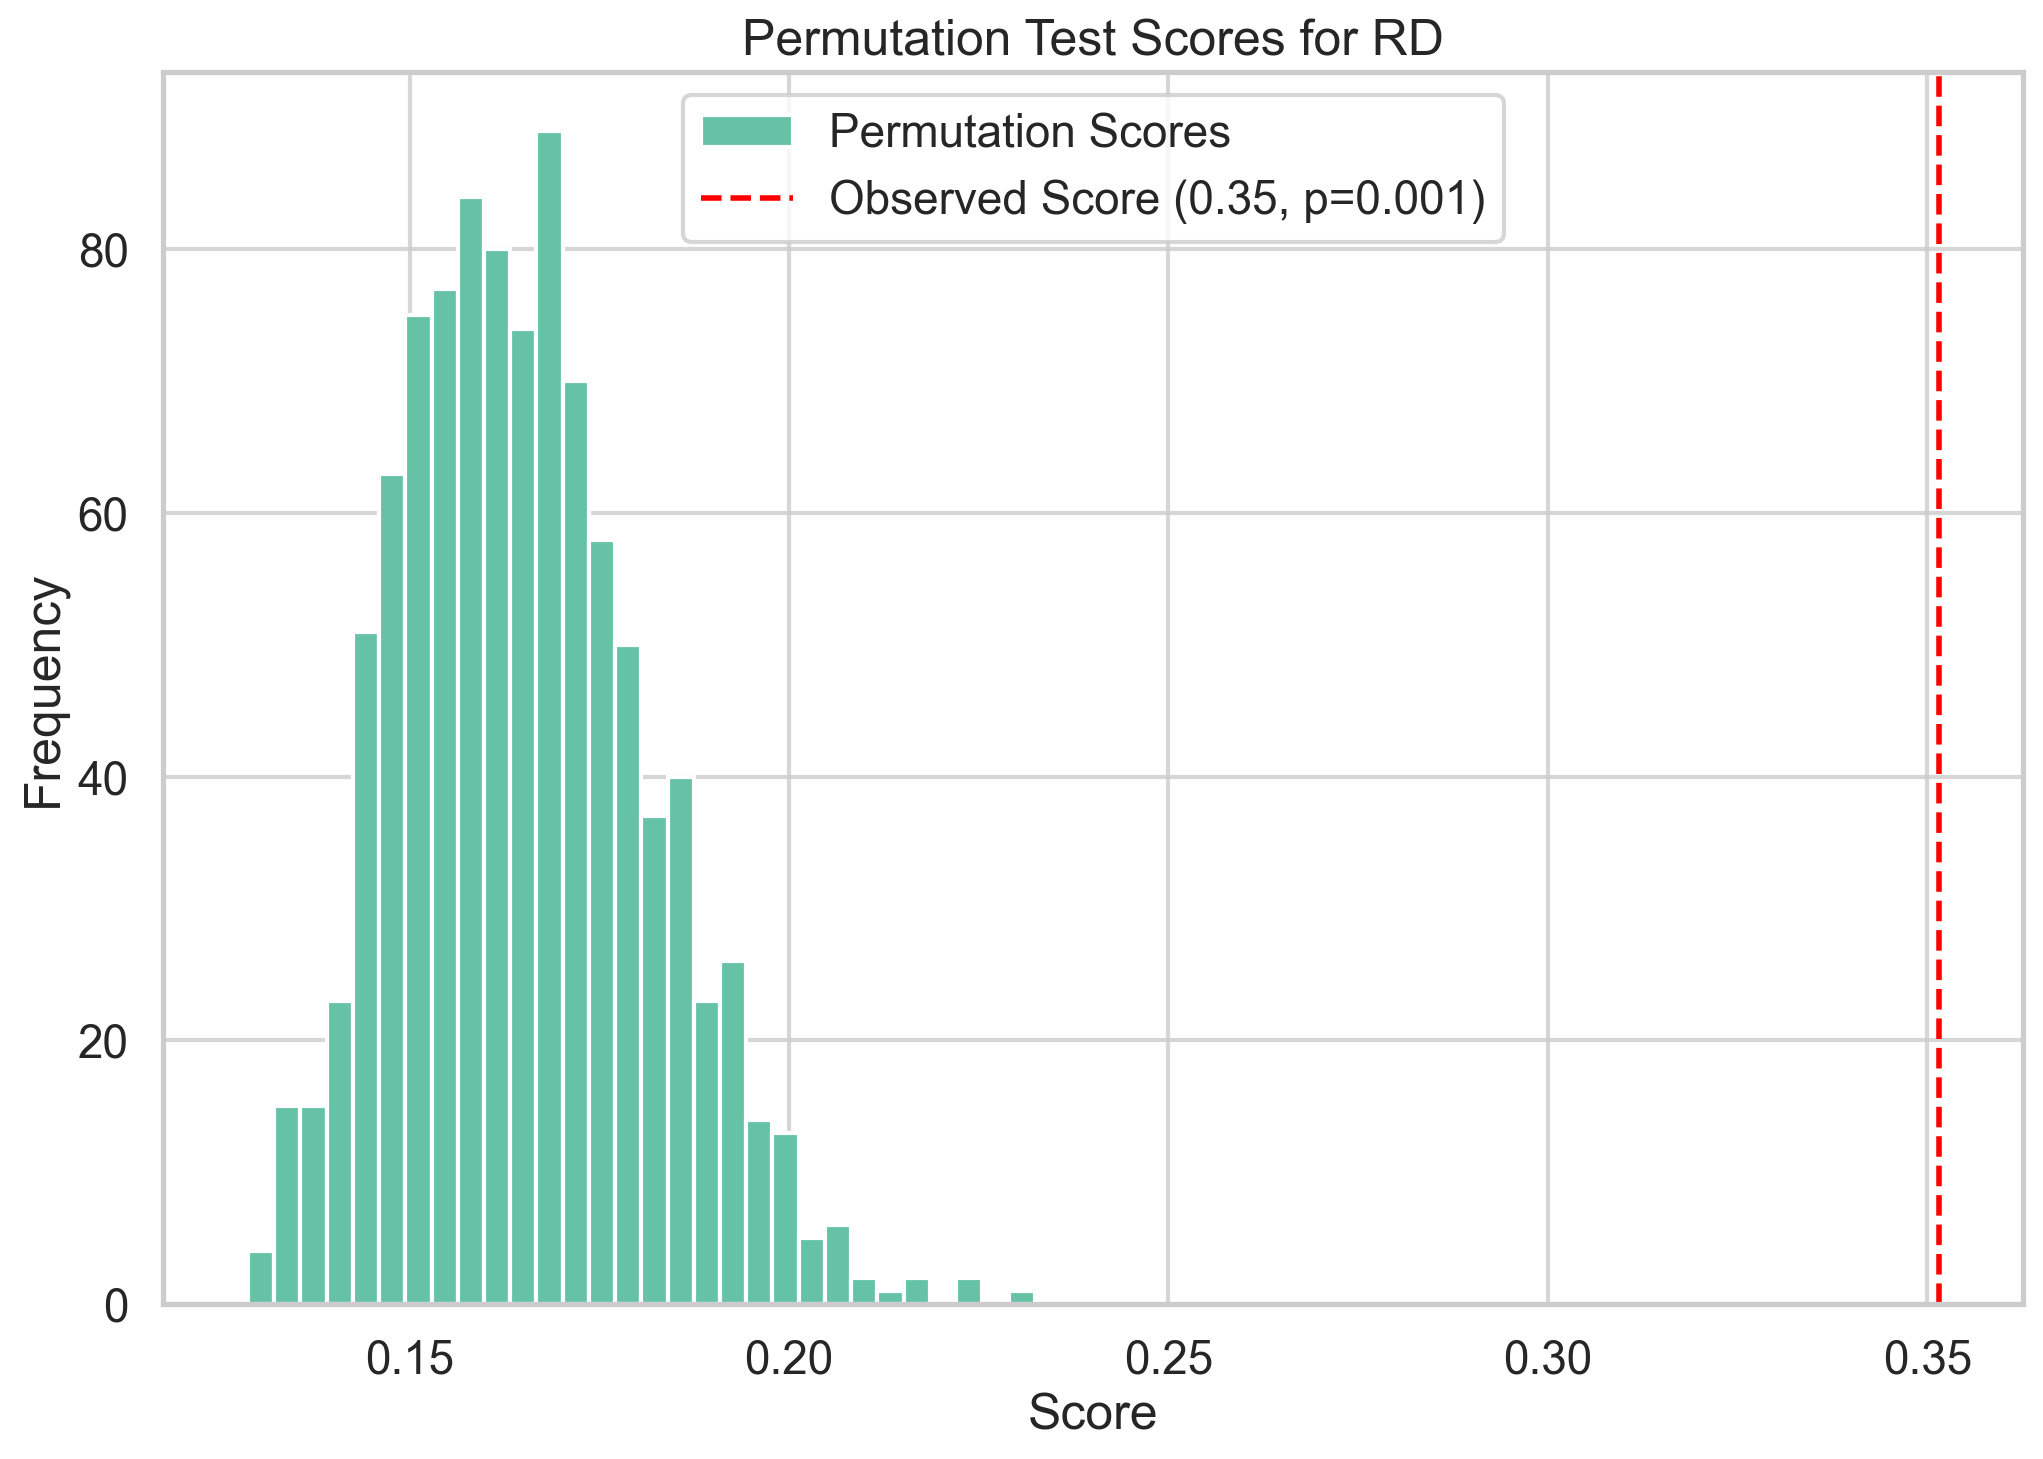

In [102]:
scorer = "average_precision"
obs = measure_df[measure_df["scorer"] == scorer].iloc[0]["permutation_score"]
p = measure_df[measure_df["scorer"] == scorer].iloc[0]["pvalue"]
plt.hist(
    measure_df[measure_df["scorer"] == scorer].iloc[0]["permutations"],
    bins=30,
    label="Permutation Scores",
)
plt.axvline(
    measure_df[measure_df["scorer"] == scorer].iloc[0]["permutation_score"],
    color="red",
    linestyle="dashed",
    linewidth=2,
    label="Observed Score ({:.2f}, p={:.3f})".format(obs, p),
)
plt.title(f"Permutation Test Scores for {metric.upper()}")
plt.xlabel("Score")

plt.ylabel("Frequency")
plt.legend()

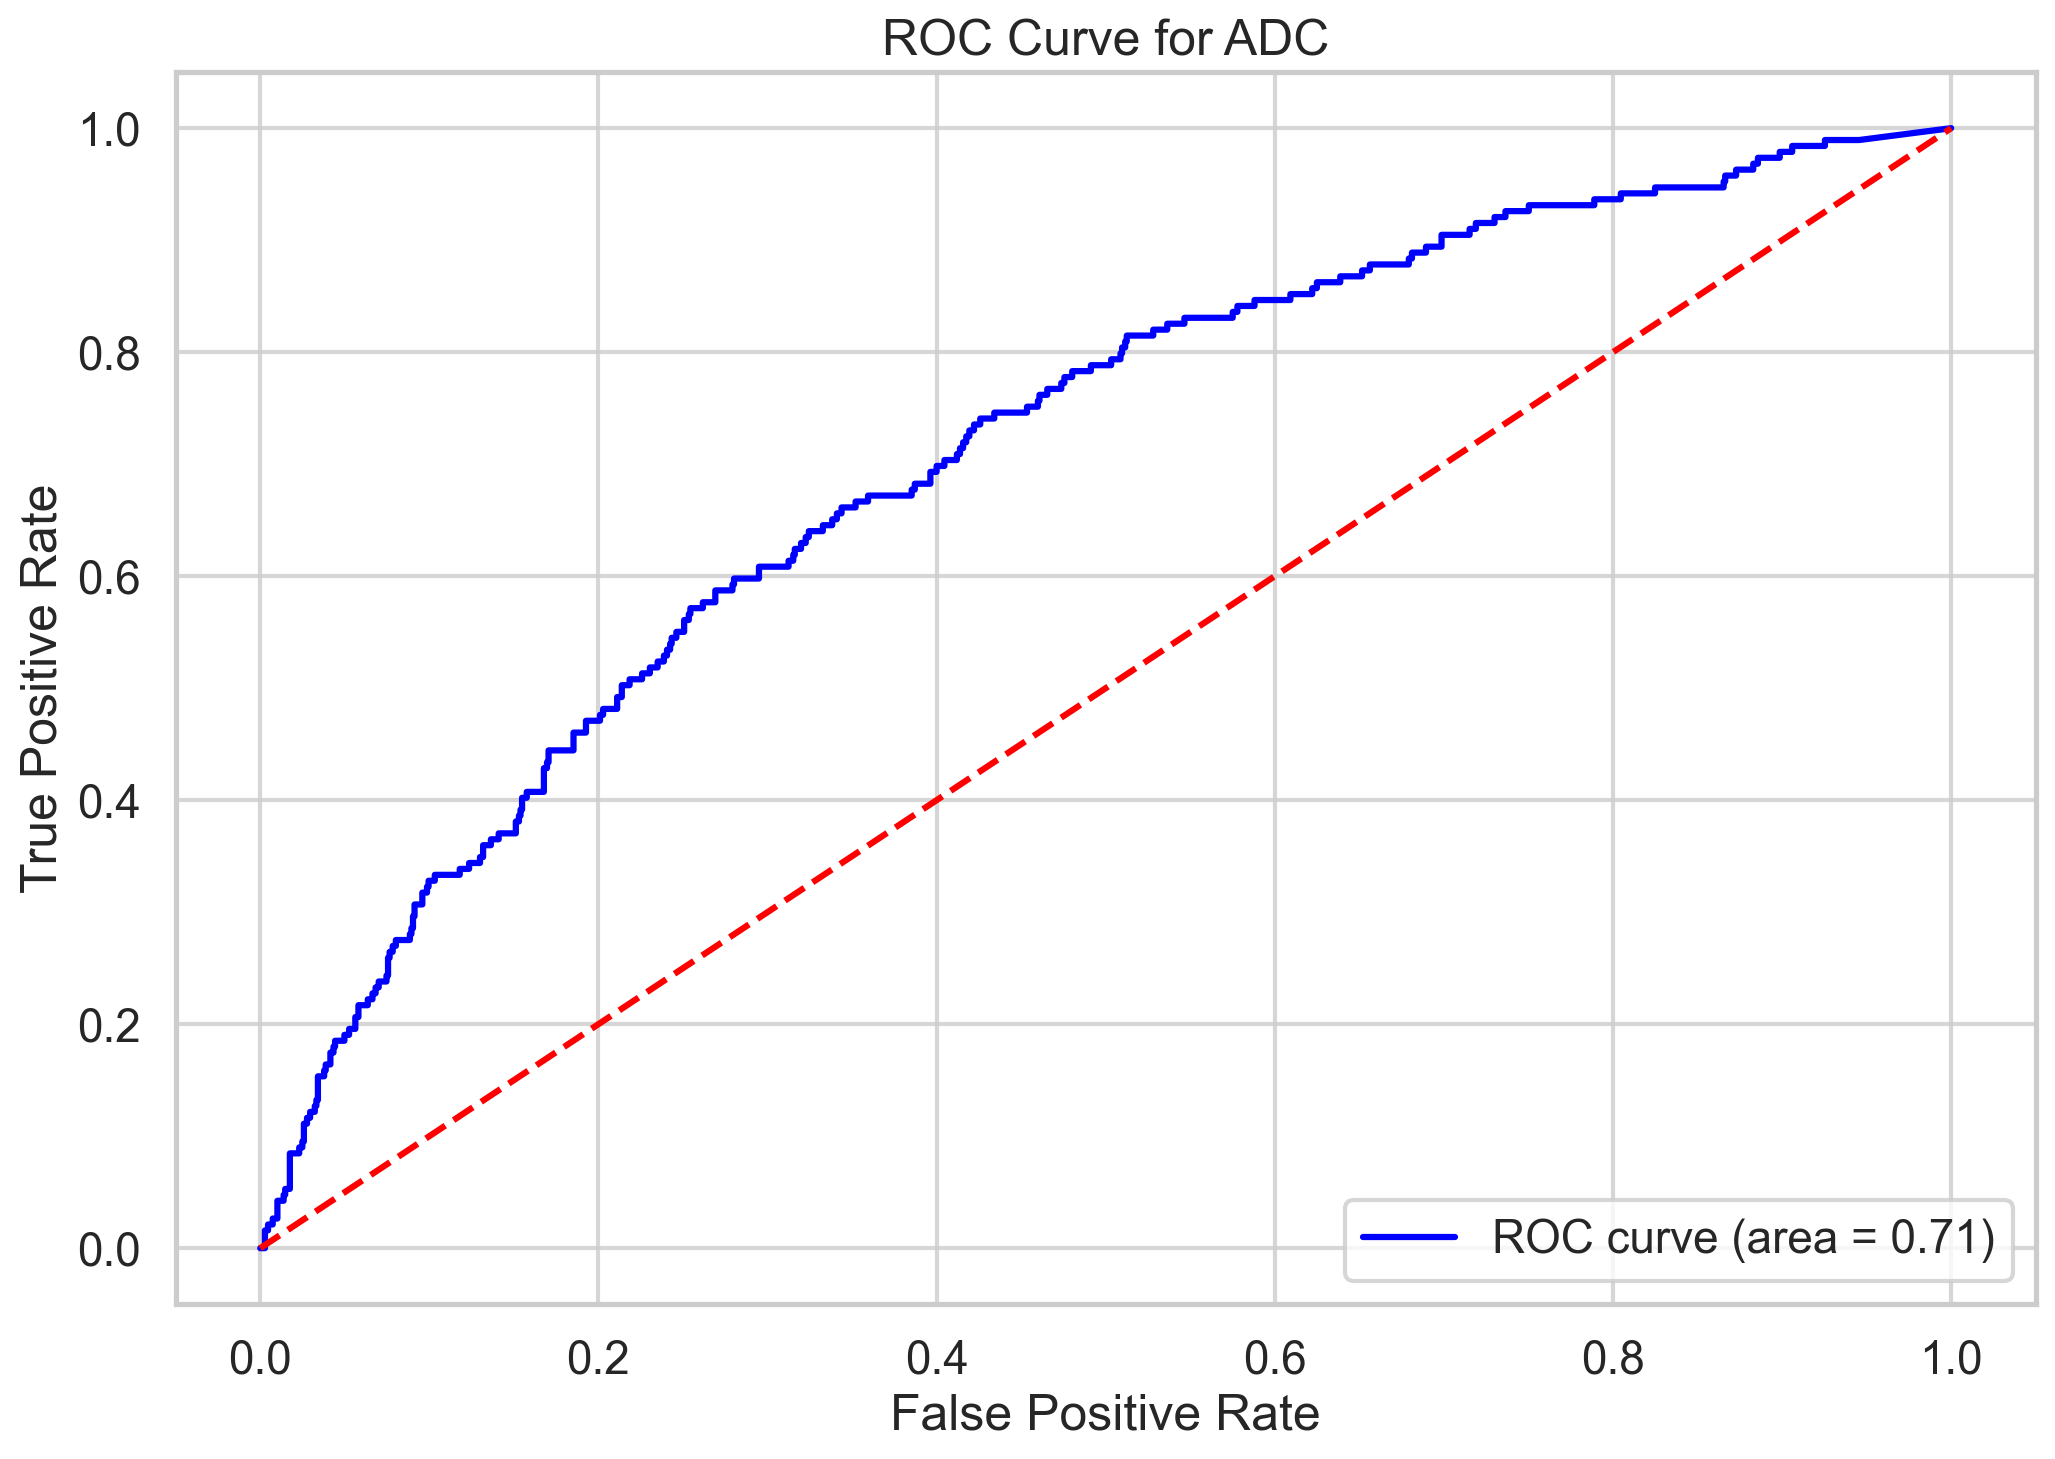

In [98]:
# ROC-AUC Curve
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(y_true, y_scores, ax=None):
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    
    if ax is None:
        fig, ax = plt.subplots()
    
    ax.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.2f})')
    ax.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver Operating Characteristic (ROC) Curve')
    ax.legend(loc='lower right')
    
    return ax
# Plot ROC Curve for each metric
for metric, preds in predictions["all"].items():
    if preds.empty:
        continue
    fig, ax = plt.subplots()
    plot_roc_curve(preds["true"], preds["proba"], ax=ax)
    ax.set_title(f"ROC Curve for {metric.upper()}")
    # savefig_nice(fig, OUTPUT_DIR / f"roc_curve_{metric}.png")
    plt.show()  # Show the plot in the notebook

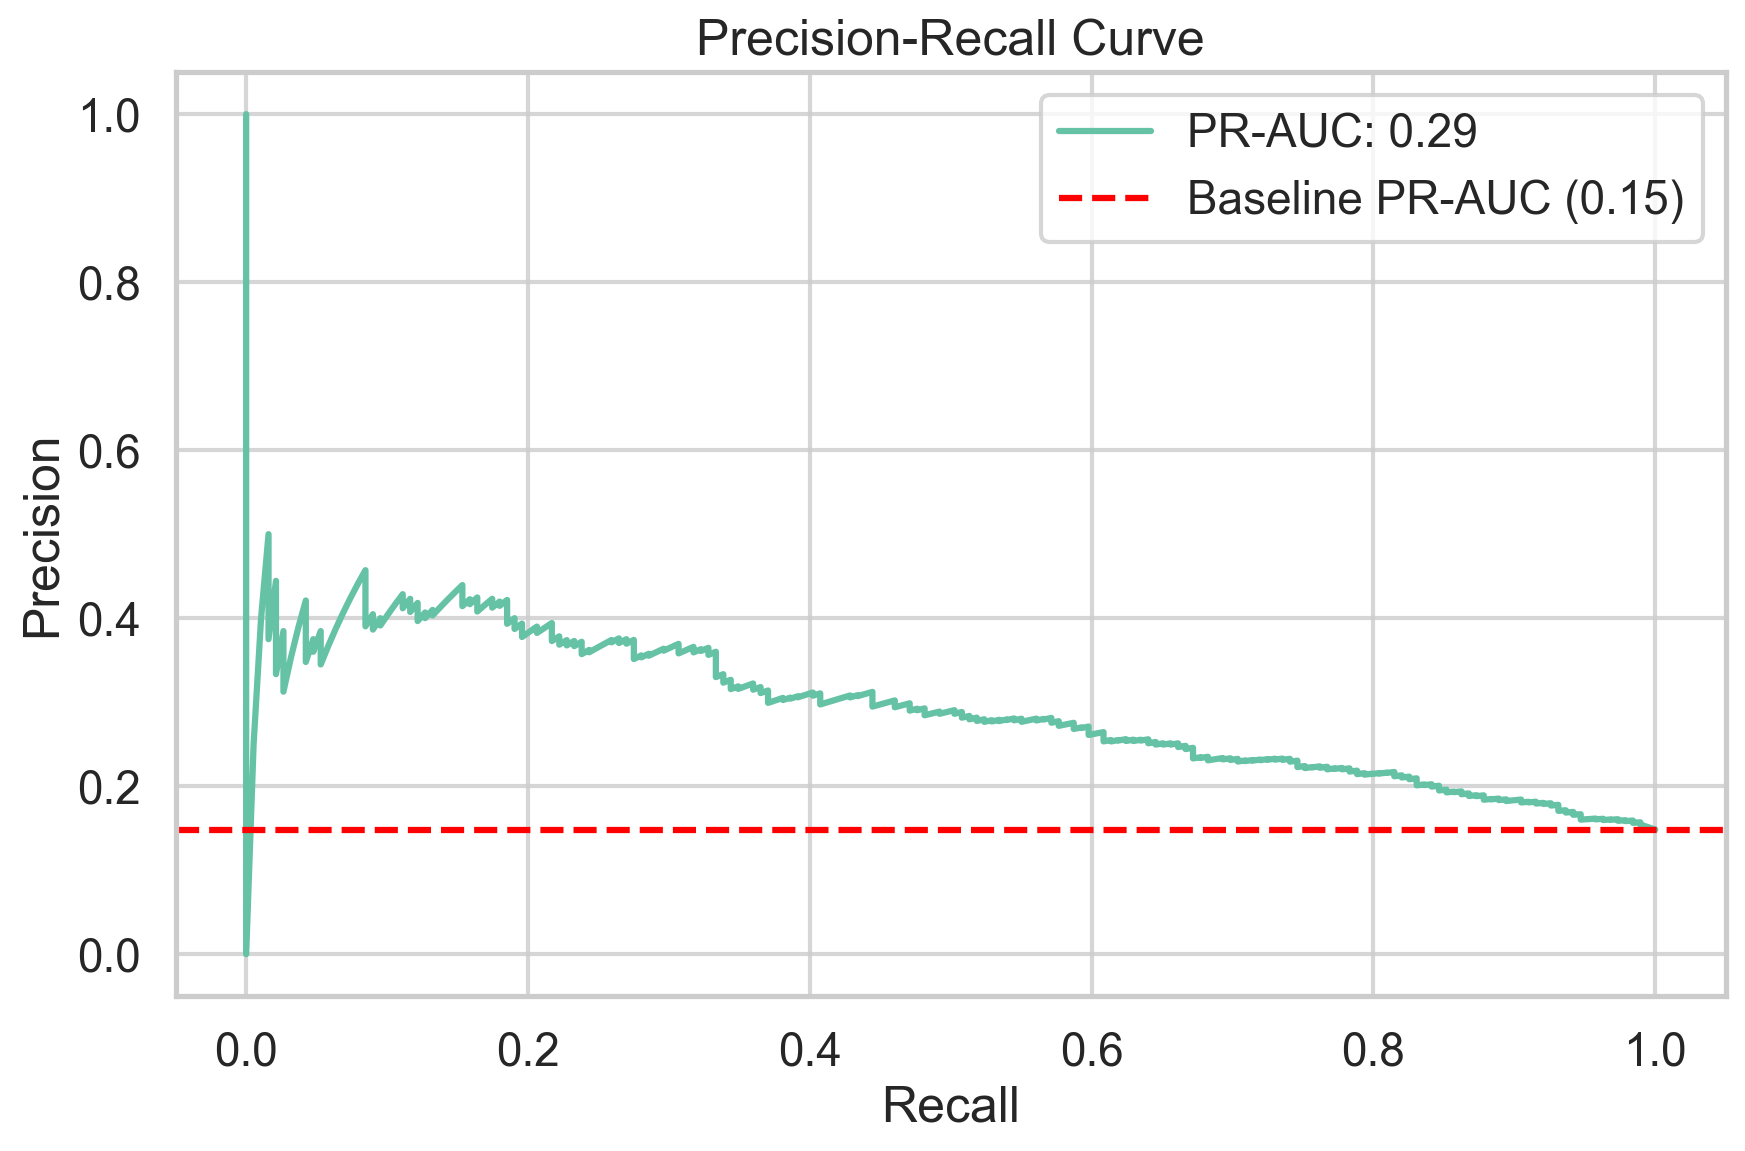

In [99]:
# precision recall curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

def plot_precision_recall_curve(y_true, y_scores, ax=None):
    """Plot Precision-Recall curve."""
    precision, recall, _ = precision_recall_curve(y_true, y_scores)
    average_precision = average_precision_score(y_true, y_scores)

    if ax is None:
        fig, ax = plt.subplots()

    ax.plot(recall, precision, label=f'PR-AUC: {average_precision:.2f}')
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.set_title('Precision-Recall Curve')
    ax.legend()
    return ax

# Plot Precision-Recall curve for each metric
fig, ax = plt.subplots(figsize=(10, 6))
for metric, preds in predictions["all"].items():
    if metric != "adc":
        continue
    ax = plot_precision_recall_curve(preds["true"], preds["proba"], ax=ax)
    # add the baseline prediction
    baseline_precision = preds["true"].mean()
    ax.axhline(baseline_precision, color='red', linestyle='--', label='Baseline PR-AUC (%.2f)' % baseline_precision)
    ax.legend()

In [ ]:
import numpy as np
import pandas as pd
import nibabel as nb
from nilearn import surface, datasets
from surfplot import Plot
from matplotlib.colors import TwoSlopeNorm  # nice diverging colours
from neuromaps.datasets import fetch_fslr
from brainspace.datasets import load_parcellation


atlas_img = nib.load(nifti_matlab)

# ---------------------------------------------------------------------
# 2.  FETCH A STANDARD SURFACE  (fsaverage5 = 10k vertices per hemi)
# ---------------------------------------------------------------------
surfaces = fetch_fslr()
lh, rh = surfaces["veryinflated"]


# ---------------------------------------------------------------------
# 3.  SAMPLE ATLAS VOXELS → SURFACE  (nearest-neighbour so labels stay int)
# ---------------------------------------------------------------------
# add schaefer parcellation (no color bar needed)
lh_parc, rh_parc = load_parcellation("schaefer")

In [ ]:
# ---------------------------------------------------------------------
# 4.  MAP REGION IDs → METRIC VALUES
#     vertices with label 0 (background) → NaN so they render transparent
# ---------------------------------------------------------------------
p_threshold = 0.05
value_threshold = 0

value_map = {}
value_map_subcortex = {"region": [], "value": [], "Hemisphere": []}

key = "gm_vol"  # or any other metric you want to visualize


# vis_df = athletes_vs_naive_results[key].copy()
vis_df = sports_vs_naive_results[climber_group_label][
    key
].copy()  # or climbers_vs_bjj_results[key].copy()
p_column = "adjusted_p_value"
value_column = "t_statistic"

value_map_lh = {}  # New: separate map for left hemisphere
value_map_rh = {}  # New: separate map for right hemisphere

for i, row in vis_df.iterrows():
    label = row[region_col]
    hemi_row = row["hemisphere"]  # Get hemisphere from your DataFrame row

    # Apply thresholds
    if (row[p_column] < p_threshold) and (np.abs(row[value_column]) > value_threshold):
        value = row[value_column]
    else:
        value = np.nan  # Set to NaN if not significant or below value_threshold

    # Populate the correct hemisphere's value_map
    # Assuming your labels are global and you use the 'hemisphere' column to distinguish
    # If your Schaefer labels are already separated by hemi (e.g., 1-200 for LH, 201-400 for RH)
    # then you might only need to check the label range and not the 'hemisphere' column.
    # For Schaefer, the labels usually run 1-N for LH and N+1 - 2N for RH
    if "schaefer" in ATLAS:
        if label > int(ATLAS.split("_")[1]):
            value_map_subcortex["region"].append(label)
            value_map_subcortex["value"].append(value)
            value_map_subcortex["Hemisphere"].append(row["hemisphere"])
        else:
            if hemi_row == "L":
                value_map_lh[label] = value
            elif hemi_row == "R":
                value_map_rh[label] = value
        # Subcortex handling would go here if you were preparing for separate subcortical visualization
        # else: # This implies it's subcortical or other non-surface region
        #     value_map_subcortex["region"].append(label)
        #     value_map_subcortex["value"].append(value)
        #     value_map_subcortex["Hemisphere"].append(row["hemisphere"])

# Vectorize mapping for left and right hemispheres separately
vec_lh = np.vectorize(lambda x: value_map_lh.get(x, np.nan))
data_lh_mapped = vec_lh(lh_parc)  # Apply LH map to LH parcellation
vec_rh = np.vectorize(lambda x: value_map_rh.get(x, np.nan))
data_rh_mapped = vec_rh(rh_parc)  # Apply RH map to RH parcellation

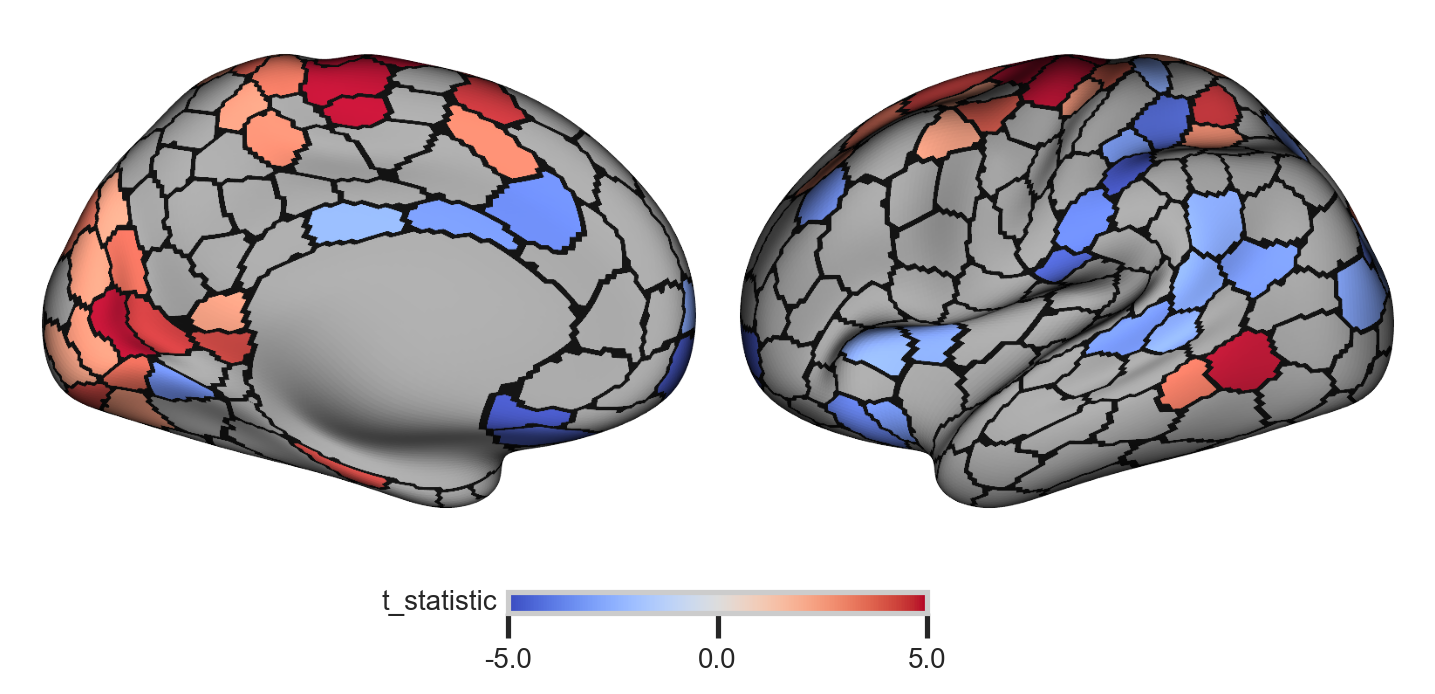

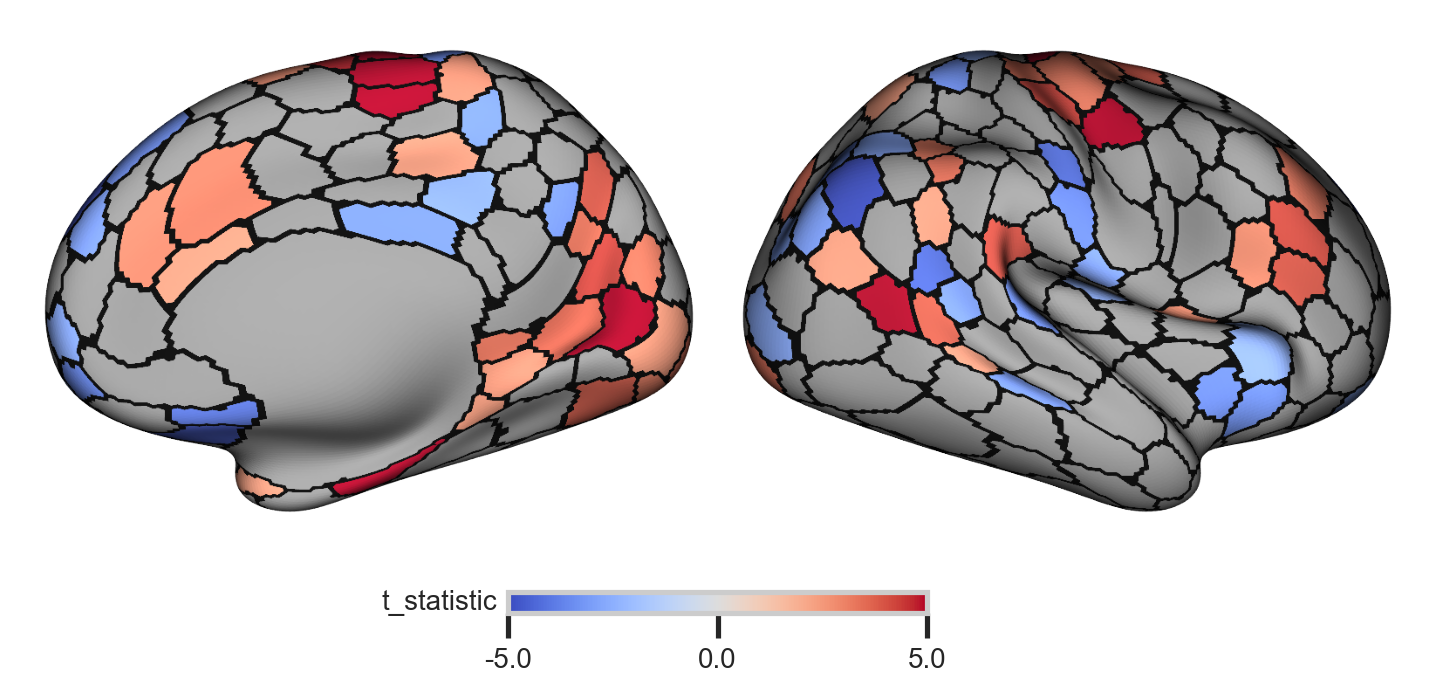

In [ ]:
vmin = -5
vmax = 5

# Corrected loop for plotting each hemisphere independently
for hemi_key, hemi_surf_data, mapped_data, parcellation_data in zip(
    ["left", "right"],  # The key for surfplot's dictionary
    [lh, rh],  # The surface object for the current hemisphere
    [data_lh_mapped, data_rh_mapped],  # The mapped data for the current hemisphere
    [lh_parc, rh_parc],  # The parcellation for the current hemisphere
):
    # ---------------------------------------------------------------------
    # 5.  BUILD THE PLOT
    # ---------------------------------------------------------------------
    pref_surf = {
        "surf_lh": hemi_surf_data if hemi_key == "left" else None,
        "surf_rh": hemi_surf_data if hemi_key == "right" else None,
    }
    p = Plot(
        **pref_surf,  # Unpack the surface dictionary
        views=["medial", "lateral"],  # Show both medial and lateral for this hemi
        size=(800, 300),  # px; change as needed
        zoom=1.6,
        layout="row",  # For a single hemisphere, row is fine
        mirror_views=False,  # Set to False, as we are plotting one hemi at a time
    )

    # ---- main data layer -------------------------------------------------
    # Pass only the data for the current hemisphere
    # The dictionary now contains only one key-value pair for the current hemisphere
    p.add_layer(
        {hemi_key: mapped_data},
        cmap="coolwarm",
        color_range=(vmin, vmax),  # Use symmetric range
        # norm=norm,  # Apply the symmetric normalization
        cbar_label=value_column,
        cbar=True,  # Ensure colorbar is shown for each plot if desired, or handle globally
    )
    # ---- outline layer ---------------------------------------------------
    p.add_layer({hemi_key: parcellation_data}, cmap="gray", as_outline=True, cbar=False)

    fig = p.build(
        # cbar_kws=dict(location="bottom", decimals=2, shrink=0.6)
    )  # Added cbar_kws for better cbar display

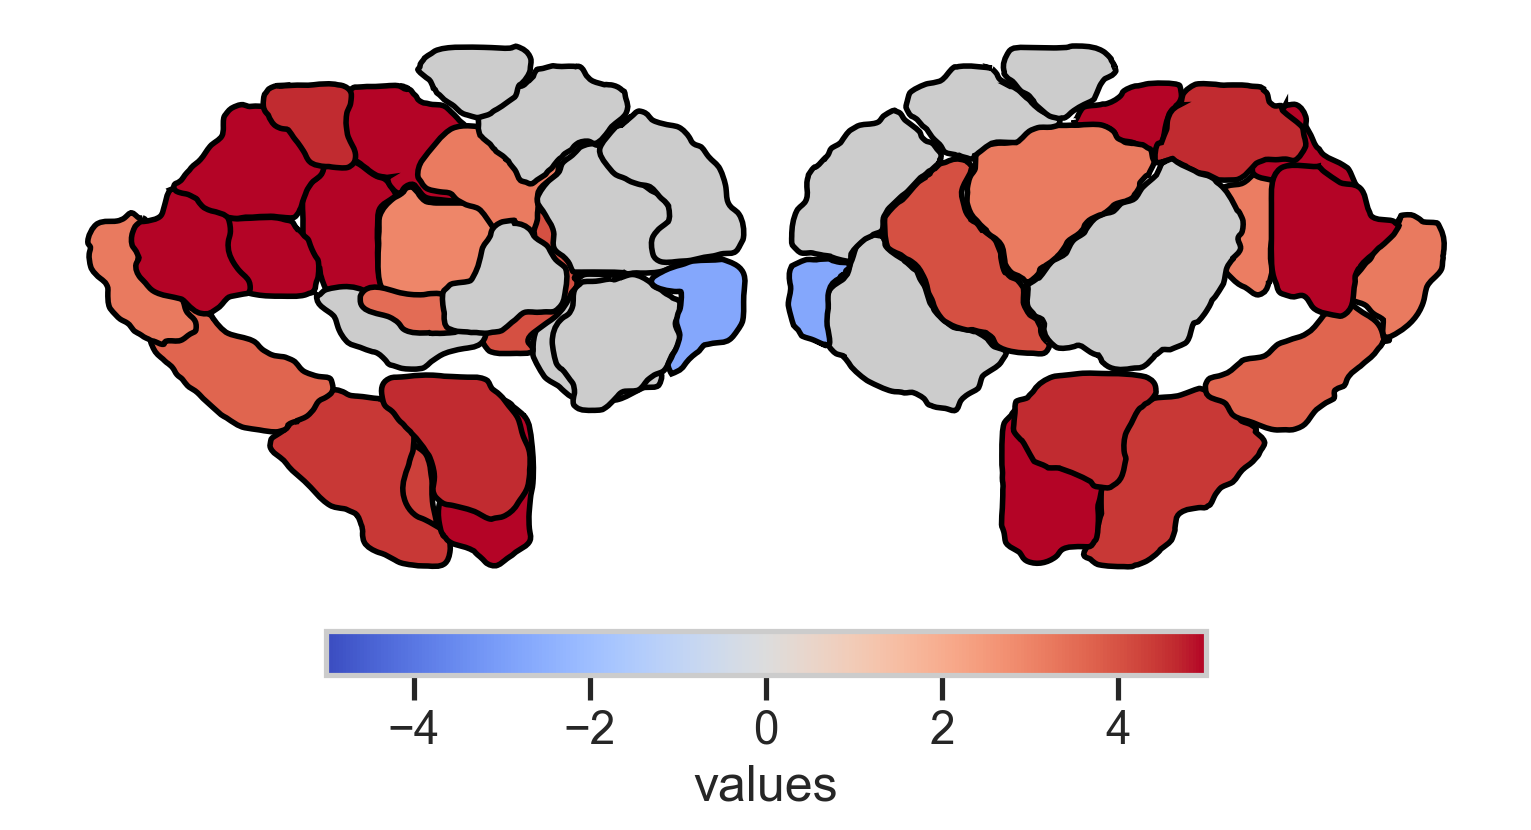

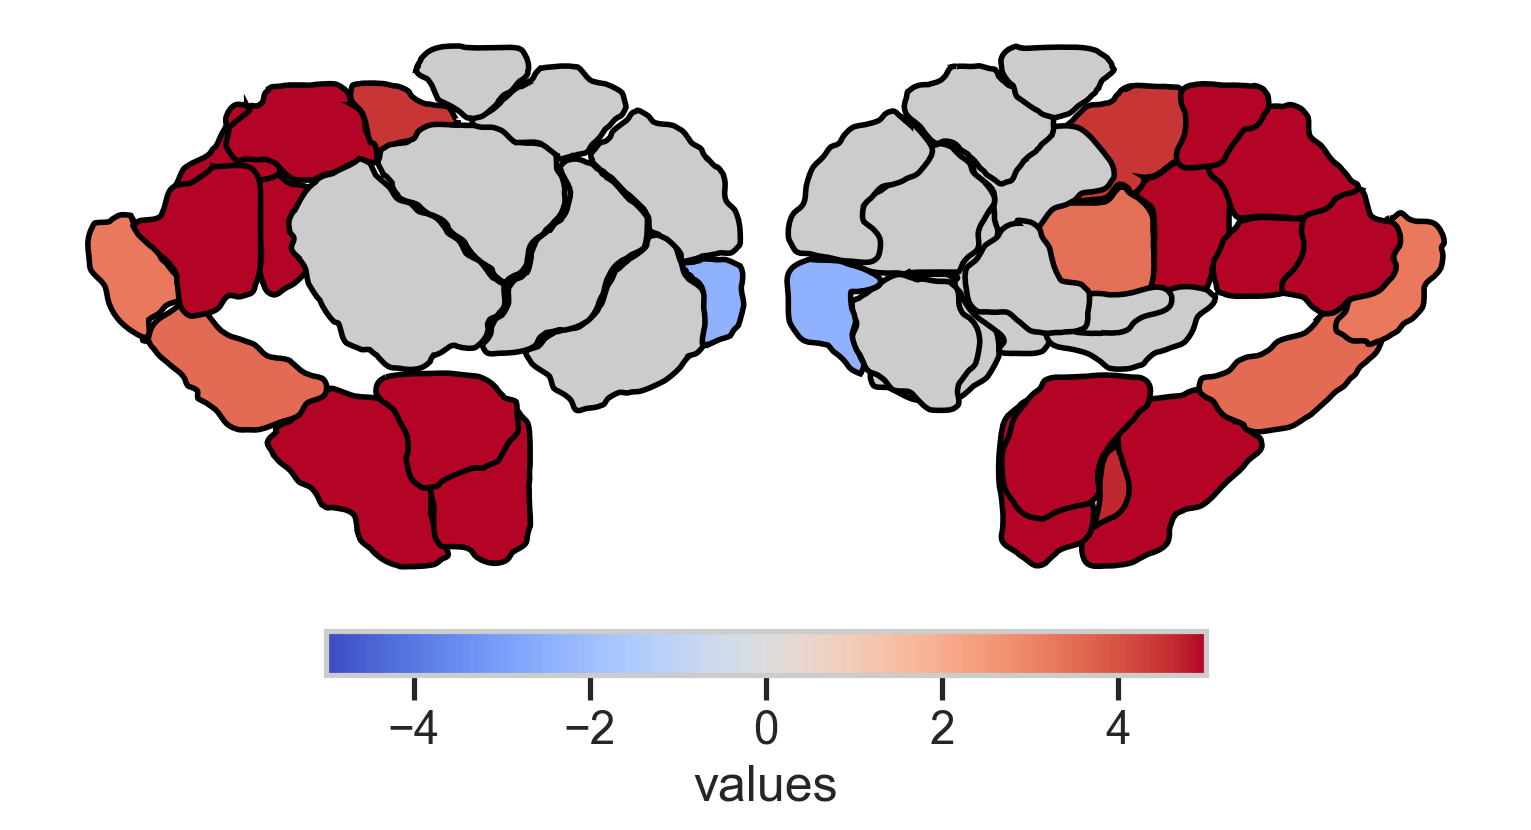

In [ ]:
from subcortex_visualization.plotting import plot_subcortical_data

subcort_df = pd.DataFrame(value_map_subcortex)
if "schaefer" in ATLAS:
    subcort_df["region"] = subcort_df["region"] - int(ATLAS.split("_")[1])


for hemi in ["L", "R"]:

    fig = plot_subcortical_data(
        subcort_df,
        atlas="Melbourne_S3",
        show_legend=True,
        hemisphere=hemi,
        cmap="coolwarm",
        line_color="black",
        line_thickness=2,
        vmin=vmin,
        vmax=vmax,
        show_figure=False,
    )

    # save figure
    # savefig_nice(fig, OUTPUT_DIR / f"fig2_subcort_{metric}_{hemi}_{value_column}.png", dpi=400)